### **Sepehr Rezaee - 99242067**

# **Intel Image Classification**

In [ ]:
! wget https://github.com/lonperman/dataset-naturaleza/archive/refs/heads/main.zip

--2022-12-14 19:12:47--  https://github.com/lonperman/dataset-naturaleza/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/lonperman/dataset-naturaleza/zip/refs/heads/main [following]
--2022-12-14 19:12:47--  https://codeload.github.com/lonperman/dataset-naturaleza/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip.1’

main.zip.1              [       <=>          ] 346.93M  29.2MB/s    in 12s     

2022-12-14 19:12:59 (28.5 MB/s) - ‘main.zip.1’ saved [363787683]



In [ ]:
!unzip main.zip

#### Import Requirements

In [ ]:
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

import torch, torchvision
from torch import nn, optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE=["#01BEFE","#FFDD00","#FF7D00","#FF006D","#ADFF02","#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 15, 10

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

**We will get each label folder and we can see that we have 6 folders**

* buildings = 0
* forest = 1
* glacier = 2
* mountain = 3
* sea = 4
* street = 5

In [ ]:
train_folders = sorted(glob('/content/dataset-naturaleza-main/seg_train/seg_train/*'))
len(train_folders)

6

**Here, We define some functions for load and show images**

In [ ]:
def load_image(img_path, resize=True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    if resize:
        img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)

    return img

def show_image(img_path):
    img = load_image(img_path)
    plt.imshow(img)
    plt.axis('off')

def show_sign_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    images = torch.as_tensor(images)
    images = images.permute(0,3,1,2)
    grid_img = torchvision.utils.make_grid(images, nrow=11)
    plt.figure(figsize=(24,12))
    plt.imshow(grid_img.permute(1,2,0))
    plt.axis('off')

<ipython-input-11-9841907c8584>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  images = torch.as_tensor(images)


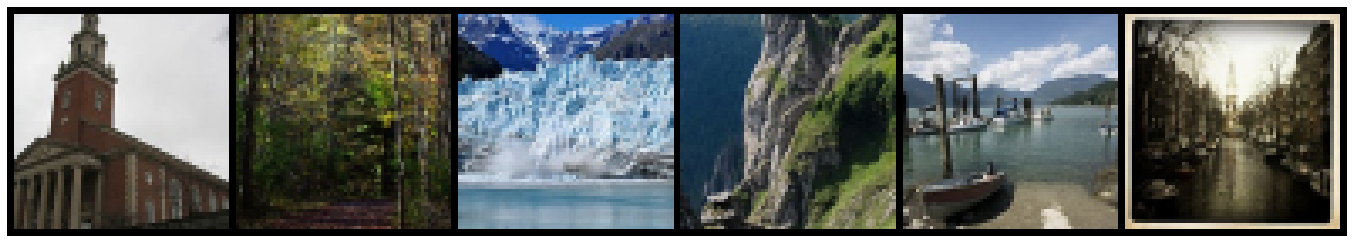

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*jpg')) for tf in train_folders]
show_sign_grid(sample_images)

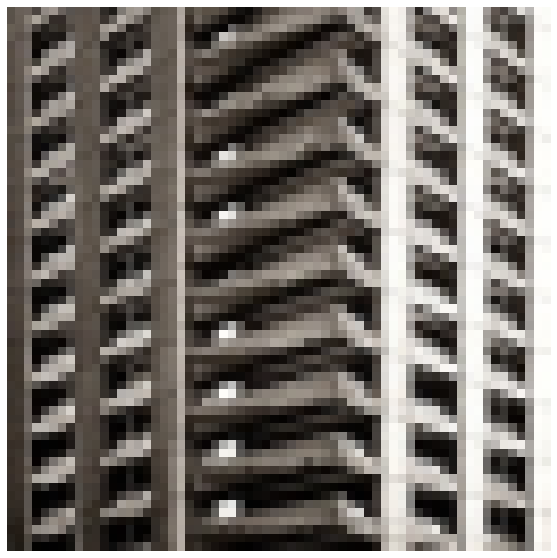

In [ ]:
img_path = glob(f'{train_folders[0]}/*jpg')[1]

show_image(img_path)

In [ ]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

class_indices = [0,1,2,3,4,5]

In [ ]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val']

for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

**Spliting the data**

In [ ]:
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'{train_folders[cls_index]}/*jpg'))
    class_name = class_names[i]
    print(f'{class_name}: {len(image_paths)}')
    np.random.shuffle(image_paths)

    ds_split = np.split(
        image_paths,
        indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
    )

    dataset_data = zip(DATASETS, ds_split)
    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


# **Distribution of classes are good, the total per class ratio is not so high**

### **We will apply some image augmentation techniques to artifically increase the size of dataset, we will apply some random resizing, rotation and horizontal flips, then we normalize the tensors using present values for each channel, this is requirement of ResNet**

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
    T.RandomResizedCrop(size=256),
    T.RandomRotation(degrees=15),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
    T.Resize(size=256),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
]),}

In [ ]:
image_datasets = {
    d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
    d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) for d in DATASETS
}

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**We will store each class total images for later use**

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 11224, 'val': 1402}

**Lets have a look at some sample images with all the transformations**

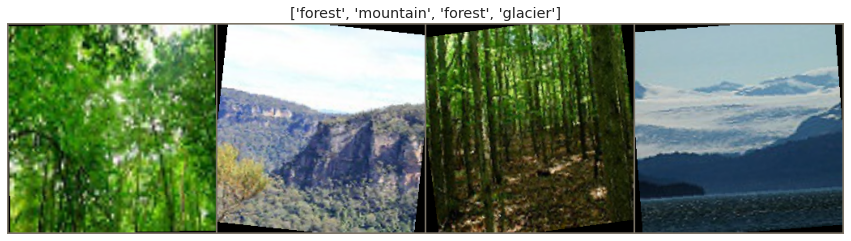

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# **Using pretrained model to classify the images**

In [ ]:
def create_model(n_classes):
    model = models.resnet34(pretrained=True)

    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

    return model.to(device)

In [ ]:
base_model = create_model(len(class_names))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

**We will create 3 helpers function to encapsualte train and eval func**

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds==labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    scheduler.step()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds==labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=5):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss_fn = nn.CrossEntropyLoss().to(device)

    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(model, data_loaders['train'], loss_fn,
                                            optimizer, device, scheduler, dataset_sizes['train'])

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(model, data_loaders['val'], loss_fn, device, dataset_sizes['val'])

        print(f'Val loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc

    print(f'Best val accuracy: {best_accuracy}')

    model.load_state_dict(torch.load('best_model_state.bin'))

    return model, history

In [ ]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device, n_epochs=20)

Epoch 1/20
----------
Train loss 0.9393215862594688 accuracy 0.6730220955096222
Val loss 0.5757464926475606 accuracy 0.8323823109843081

Epoch 2/20
----------
Train loss 0.6488722799686384 accuracy 0.7657697790449038
Val loss 0.40412467004737995 accuracy 0.8801711840228246

Epoch 3/20
----------
Train loss 0.5539407715540252 accuracy 0.8030114041339986
Val loss 0.29286956492613436 accuracy 0.905848787446505

Epoch 4/20
----------
Train loss 0.5079642503445335 accuracy 0.8168210976478975
Val loss 0.24345334876873304 accuracy 0.9194008559201141

Epoch 5/20
----------
Train loss 0.474652660820525 accuracy 0.827512473271561
Val loss 0.21735042443818117 accuracy 0.9251069900142653

Epoch 6/20
----------
Train loss 0.4540102034174928 accuracy 0.836600142551675
Val loss 0.24971530432521002 accuracy 0.9186875891583453

Epoch 7/20
----------
Train loss 0.43124621592914114 accuracy 0.8440841054882395
Val loss 0.22216046887575414 accuracy 0.927960057061341

Epoch 8/20
----------
Train loss 0.3330

# **Get test data**

In [ ]:
test_folders = sorted(glob('/content/dataset-naturaleza-main/seg_test/seg_test/*'))
len(test_folders)

6

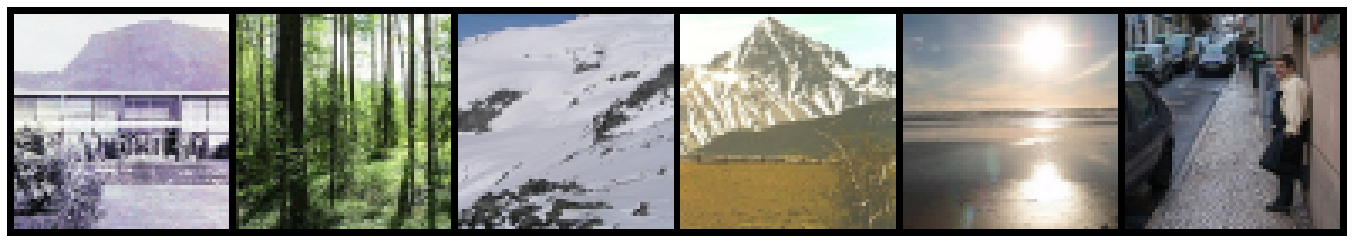

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*jpg')) for tf in test_folders]
show_sign_grid(sample_images)

### **Preprocessing the test data like train dataset**

In [ ]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

class_indices = [0,1,2,3,4,5]

DATASETS = ['test']

for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'{test_folders[cls_index]}/*jpg'))
    class_name = class_names[i]
    print(f'{class_name}: {len(image_paths)}')
    np.random.shuffle(image_paths)

    ds_split = np.split(
        image_paths,
        indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
    )

    dataset_data = zip(DATASETS, ds_split)
    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
    T.Resize(size=256),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
]),}

image_datasets = {
    d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
    d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) for d in DATASETS
}

dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['test'].classes

dataset_sizes

buildings: 437
forest: 474
glacier: 553
mountain: 525
sea: 510
street: 501


{'test': 2398}

# **Evaluation**

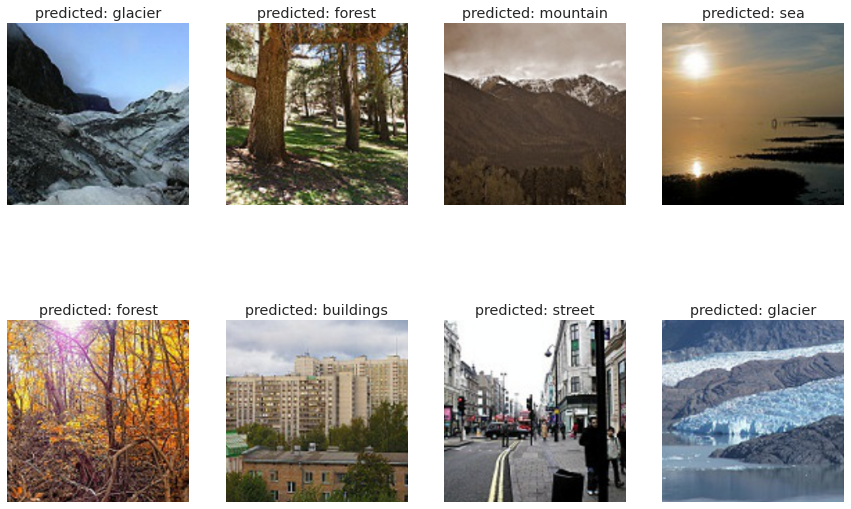

In [ ]:
def show_predictions(model, class_names, n_images=6):
    model = model.eval()
    images_handeled = 0
    plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            for j in range(inputs.shape[0]):
                images_handeled += 1
                ax = plt.subplot(2, n_images//2, images_handeled)
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                ax.axis('off')

                if images_handeled == n_images:
                    return

show_predictions(base_model, class_names, n_images=8)

### **See the classification report to understand the performance of the model**

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            predictions.extend(preds)
            real_values.extend(labels)
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()

    return predictions, real_values

y_pred, y_test = get_predictions(base_model, data_loaders['test'])

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.89      0.90      0.90       349
      forest       0.99      0.99      0.99       379
     glacier       0.90      0.87      0.88       442
    mountain       0.89      0.85      0.87       420
         sea       0.92      0.98      0.95       408
      street       0.91      0.92      0.91       400

    accuracy                           0.92      2398
   macro avg       0.92      0.92      0.92      2398
weighted avg       0.92      0.92      0.92      2398



In [ ]:
!rm -rf data/pred_test

**It is not bad, we have 0.9 average score for precision score among all class, but I have a little concern on recall score for class glacier and mountain, perhaps we need more data for that or other way of optimization to enhance that, but I am happy with the current score, and f1_score is good as well**

# **Prediction on prediction dataset**

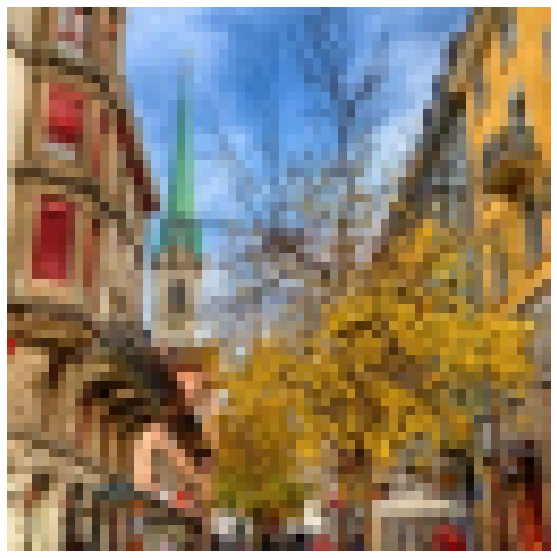

In [ ]:
show_image('/content/dataset-naturaleza-main/seg_pred/seg_pred/10004.jpg')

Looks like building/street to me

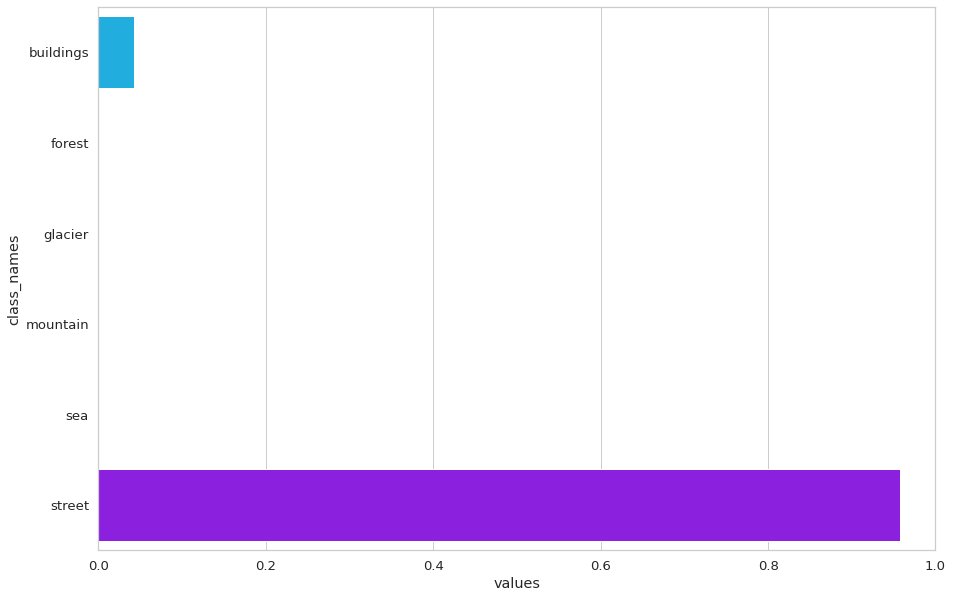

In [ ]:
def predict_proba(model, img_path):
    img = Image.open(img_path)
    img = img.convert('RGB')
    img = transforms['test'](img).unsqueeze(0)

    pred = model(img.to(device))
    pred = F.softmax(pred,1)
    return pred.detach().cpu().numpy().flatten()

def show_prediction_confidence(prediction, class_names):
    pred_df = pd.DataFrame({'class_names': class_names, 'values': prediction})
    sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
    plt.xlim([0, 1]);

pred = predict_proba(base_model, '/content/dataset-naturaleza-main/seg_pred/seg_pred/10004.jpg')
show_prediction_confidence(pred, class_names)

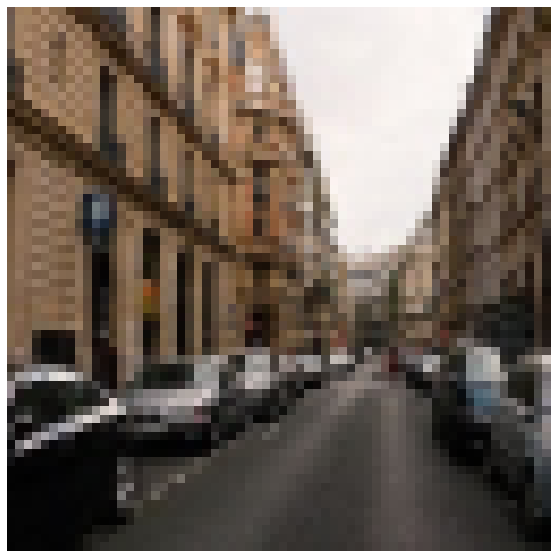

In [ ]:
show_image('/content/dataset-naturaleza-main/seg_pred/seg_pred/10079.jpg')

Absolutly, It is a street

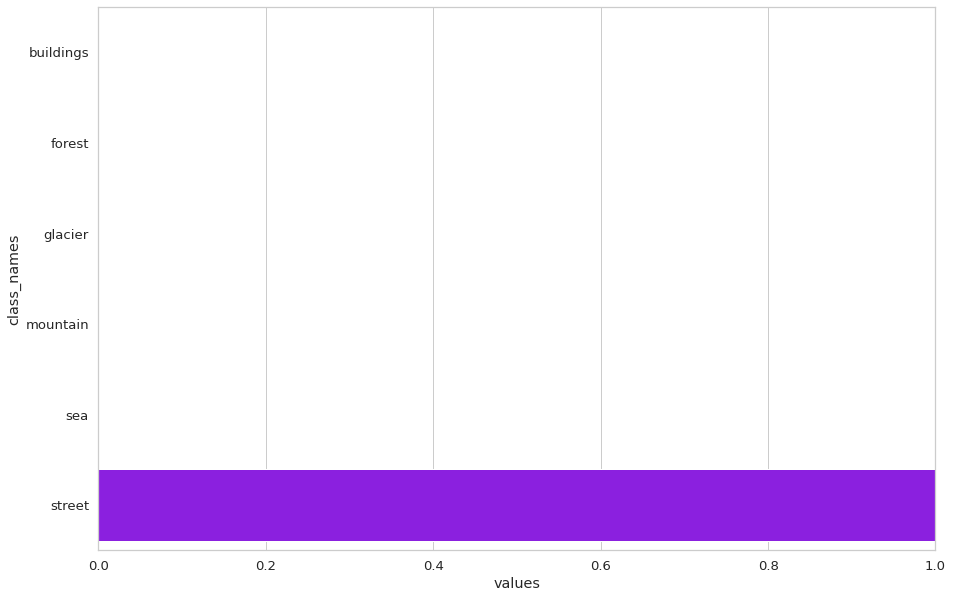

In [ ]:
pred = predict_proba(base_model, '/content/dataset-naturaleza-main/seg_pred/seg_pred/10079.jpg')
show_prediction_confidence(pred, class_names)

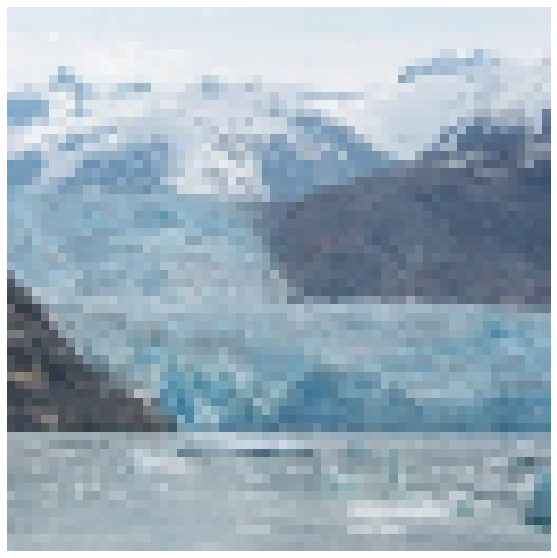

In [ ]:
show_image('/content/dataset-naturaleza-main/seg_pred/seg_pred/101.jpg')

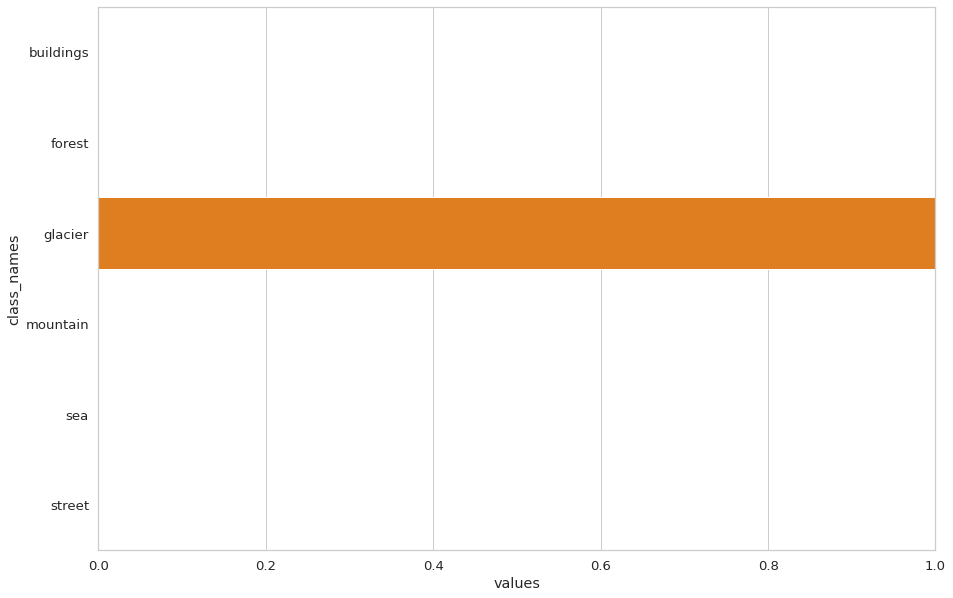

In [ ]:
pred = predict_proba(base_model, '/content/dataset-naturaleza-main/seg_pred/seg_pred/101.jpg')
show_prediction_confidence(pred, class_names)